In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit # Speeds up the computation time
from sklearn.decomposition import PCA

plt.rcParams['font.size'] = 14

# Generating the Ising Lattices

<h2 style='color:green'> Simulating Lattice via Monte Carlo and Metropolis-Hastings Algorithm </h2>

In [2]:
@njit
def montecarloI(box, T, J=1):
    '''
    Performs one Monte Carlo sweep at a given temperature over a 2D Ising lattice of spins.
    
    PARAMETERS:
     • box: 2D (shape (x, y)) lattice of spins
     • T: Temperature at which Monte Carlo sweep is performed
     • J: Interaction energy; set by default to 1
     
    RETURNS:
     • box: The lattice after one Monte Carlo sweep has been performed
     • en: The energy of the new lattice, a number
     • mag: The magnetization (sum of all spins) of the new lattice, a number
    '''
    
    x,y = box.shape

    en = 0 # Initialising interaction energy
    for i in range(x):
        for j in range(y):
            sides = box[i-1,j] + box[i,j-1] # By the loop over every particle, this loops over every bond
            en -= box[i,j]*sides
    en *= J

    mag = np.sum(box)
    
    for p in range(x*y):
        i = int(x*np.random.uniform(0,1)) # Choosing a random x-coordinate in the lattice
        j = int(y*np.random.uniform(0,1)) # Choosing a random y-coordinate in the lattice
        
        nlatij = -box[i,j] # Trial is flip of random spin
        
        sides = box[(i+1)%x,j] + box[(i-1)%x,j] + box[i,(j+1)%y] + box[i,(j-1)%y]
        dE = -J*(nlatij - box[i,j])*sides # Change in energy from trial flip/rotation
        
        if dE <= 0: # Trials lowering energies are always accepted
            en += dE
            mag += -box[i,j] + nlatij
            box[i,j] = nlatij
        else:
            r = np.random.uniform(0,1)
            if r <= np.exp(-dE/T): # Trials increasing energy are accepted with a probability from the Boltzmann distribution
                en += dE
                mag += -box[i,j] + nlatij
                box[i,j] = nlatij
    mag = np.sum(box)
    return box, en, mag

In [3]:
@njit
def createIsing(p, T, J=1, mcs=10_000):
    '''
    Creates a 2D Ising lattice of spins at a given temperature.
    
    PARAMETERS:
     • p: Number of spins along one dimension of the 2D lattice
     • T: Temperature at which Monte Carlo sweep is performed, and so temperature of system
     • J: Interaction energy between spins; set by default to 1
     • mcs: Number of Monte Carlo sweeps to be run; set by default to 10_000
     
    RETURNS:
     • box: The lattice at thermal equilibrium at the given temperature
     • e: The equilibrium energies of the lattice, a 1D array with mcs elements
     • m: The equilibrium sums of all spins of the lattice, a 1D array with mcs elements
    '''

    box = np.ones((p, p)) # Create lattice for Monte Carlo sweeps to be performed on
    e = np.zeros(mcs) # Initialise array of energies
    m = np.zeros(mcs) # Initialise array of sums of spins
    for i in range(mcs):
        box, en, mag = montecarloI(box, T=T, J=J)
        e[i] = en
        m[i] = mag
        
    return box, e, m

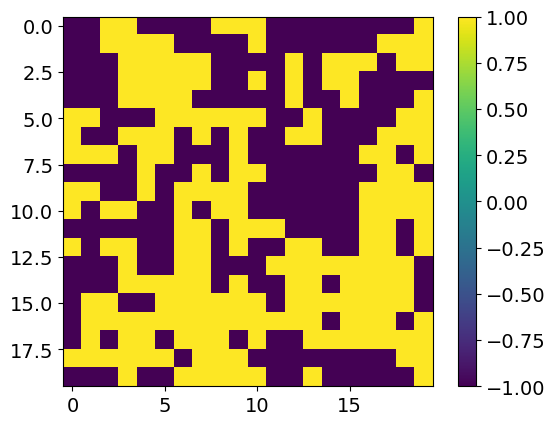

In [4]:
# Initialise njit

p = 20
T = 4
box, E, _ = createIsing(p,T)

plt.imshow(box)
plt.colorbar()
plt.show()

<h2 style='color:green'> Checking for Equilibrium </h2>

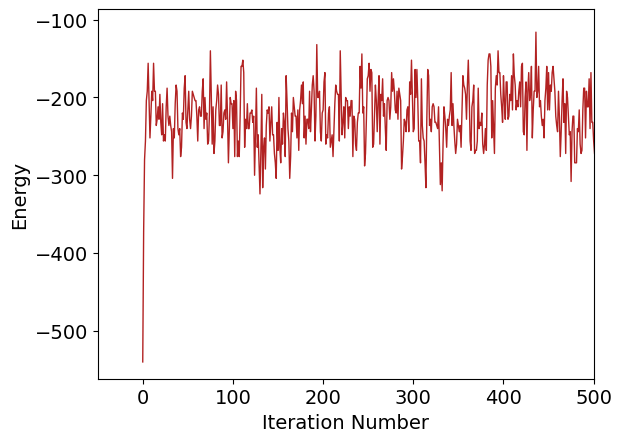

In [5]:
plt.plot(E, lw=1, color='firebrick')
plt.xlim(-50,500)
plt.xlabel('Iteration Number')
plt.ylabel('Energy')
plt.show()

<h2 style='color:green'> Finding the Critical Point using just Monte Carlo Sweeps </h2>

In [6]:
%%time

Ts = np.linspace(0.1,5.0,50)
es = np.zeros_like(Ts) # Average Energy of the Lattice
cs = np.zeros_like(Ts) # Average Magnetisation of the Lattice
ms = np.zeros_like(Ts) # Specific Heat of the Lattice
ss = np.zeros_like(Ts) # Magnetic Susceptibility of the Lattice
for i,t in enumerate(Ts):
    _, e, m = createIsing(20,t, mcs=20_000)
    
    en = np.mean(e)
    en2 = np.mean(e**2)
    es[i] = en
    cs[i] = (en2 - en**2)/t/t
    
    mag = np.mean(abs(m))
    mag2 = np.mean(m**2)
    ms[i] = mag
    ss[i] = (mag2 - mag**2)/t/t

CPU times: user 12.6 s, sys: 89.4 ms, total: 12.7 s
Wall time: 12.9 s


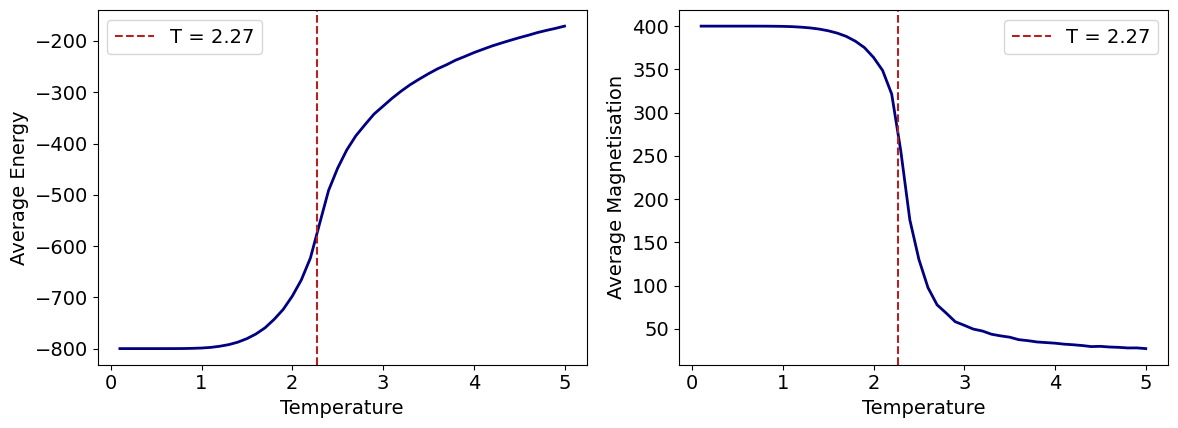

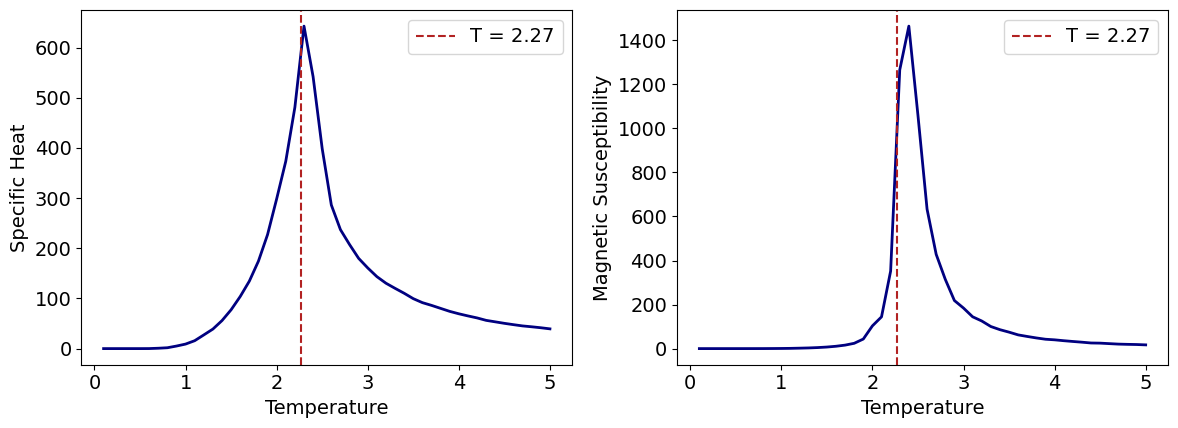

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4.5))

ax[0].plot(Ts, es, linewidth=2, color='navy')
ax[0].axvline(2.27, ls='--', color='firebrick', label='T = 2.27')
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('Average Energy')
ax[0].legend()

ax[1].plot(Ts, ms, linewidth=2, color='navy')
ax[1].axvline(2.27, ls='--', color='firebrick', label='T = 2.27')
ax[1].set_xlabel('Temperature')
ax[1].set_ylabel('Average Magnetisation')
ax[1].legend()

plt.tight_layout()
plt.show()

#-------------------------------------------------------------------

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4.5))

ax[0].plot(Ts, cs, linewidth=2, color='navy')
ax[0].axvline(2.27, ls='--', color='firebrick', label='T = 2.27')
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('Specific Heat')
ax[0].legend()

ax[1].plot(Ts, ss, linewidth=2, color='navy')
ax[1].axvline(2.27, ls='--', color='firebrick', label='T = 2.27')
ax[1].set_xlabel('Temperature')
ax[1].set_ylabel('Magnetic Susceptibility')
ax[1].legend()

plt.tight_layout()
plt.show()

# Performing the PCA

In [8]:
def matrix_for_PCA(p, Ts, ncpt, space, eq_sweeps):
    mc_sweeps = eq_sweeps + 1 + (ncpt-1)*space

    X = np.zeros((len(Ts)*ncpt, p*p))
    box, _, _ = createIsing(p, Ts[0])

    for i,t in enumerate(Ts):
        for j in range(mc_sweeps):
            box, _, _ = montecarloI(box, t)

            if j >= eq_sweeps:
                if j%space == 0:
                    num = (j-eq_sweeps)//space
                    X[num + i*ncpt] = box.flatten()
    
    return X

def PCA(X):
    vals, vecs = np.linalg.eig(X.T@X)
    vecs = vecs.T
    ind = np.argsort(vals)

    # Identifying the eigenvectors with the largest eigenvalues
    y1 = vecs[ind[-1]]
    y2 = vecs[ind[-2]]
    
    # Projecting the matrix down to its eigenvectors
    z1 = X@y1
    z2 = X@y2
    
    return z1, z2

In [9]:
%%time

p = [20,40,60]
Ts = np.arange(1.6,3.0,0.1)
ncpt = 500 # No. of Configurations Per Temperature
space = 100 # Spacing between mc_sweeps taken as configurations
eq_sweeps = 5000

X1 = matrix_for_PCA(p[0], Ts, ncpt, space, eq_sweeps)
X2 = matrix_for_PCA(p[1], Ts, ncpt, space, eq_sweeps)
X3 = matrix_for_PCA(p[2], Ts, ncpt, space, eq_sweeps)

CPU times: user 1min 56s, sys: 364 ms, total: 1min 56s
Wall time: 1min 59s


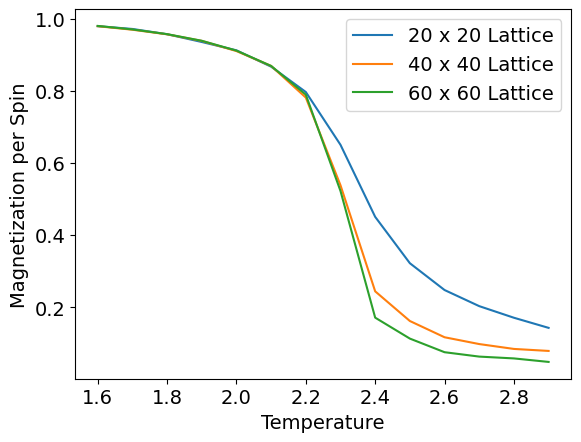

In [10]:
# Checking that X was produced correctly by plotting the magnetization per spin against the temperature
# We should see the same trend as before

mag1 = np.zeros_like(Ts)
mag2 = np.zeros_like(Ts)
mag3 = np.zeros_like(Ts)
for i in range(len(Ts)):
    for j in range(ncpt):
        mag1[i] += abs(np.sum(X1[i*ncpt + j])) / ncpt
        mag2[i] += abs(np.sum(X2[i*ncpt + j])) / ncpt
        mag3[i] += abs(np.sum(X3[i*ncpt + j])) / ncpt
    
plt.plot(Ts, mag1/400, label='20 x 20 Lattice')
plt.plot(Ts, mag2/1600, label='40 x 40 Lattice')
plt.plot(Ts, mag3/3600, label='60 x 60 Lattice')
plt.xlabel('Temperature')
plt.ylabel('Magnetization per Spin')
plt.legend()
plt.show()

In [11]:
z1_1, z2_1 = PCA(X1)
z1_2, z2_2 = PCA(X2)
z1_3, z2_3 = PCA(X3)

temps = np.repeat(Ts, ncpt) # Array of temperatures corresponding to each row of X

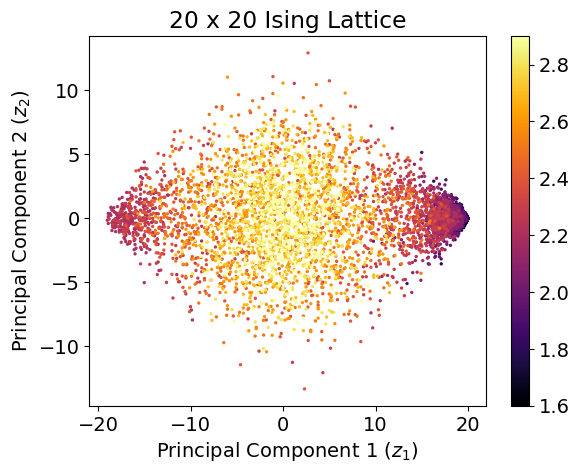

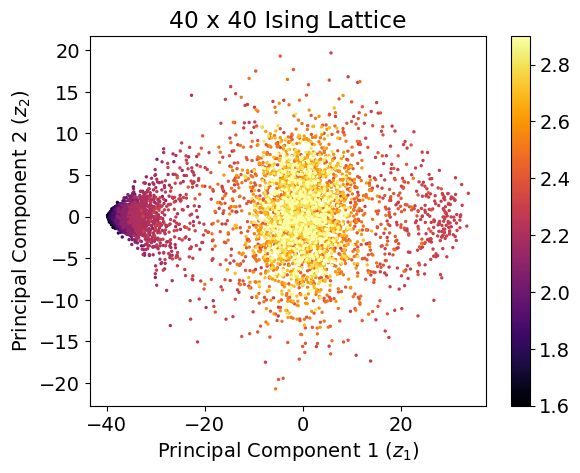

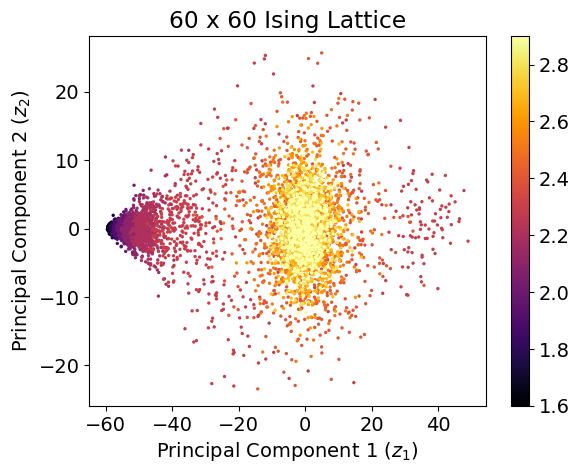

In [12]:
plt.scatter(z1_1, z2_1, c=temps, cmap='inferno', s=2)
plt.xlabel('Principal Component 1 ($z_1$)')
plt.ylabel('Principal Component 2 ($z_2$)')
plt.title('20 x 20 Ising Lattice')
plt.colorbar()
plt.show()

plt.scatter(z1_2, z2_2, c=temps, cmap='inferno', s=2)
plt.xlabel('Principal Component 1 ($z_1$)')
plt.ylabel('Principal Component 2 ($z_2$)')
plt.title('40 x 40 Ising Lattice')
plt.colorbar()
plt.show()

plt.scatter(z1_3, z2_3, c=temps, cmap='inferno', s=2)
plt.xlabel('Principal Component 1 ($z_1$)')
plt.ylabel('Principal Component 2 ($z_2$)')
plt.title('60 x 60 Ising Lattice')
plt.colorbar()
plt.show()

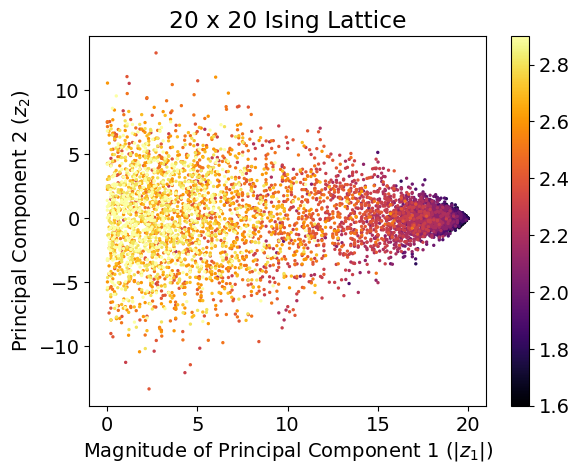

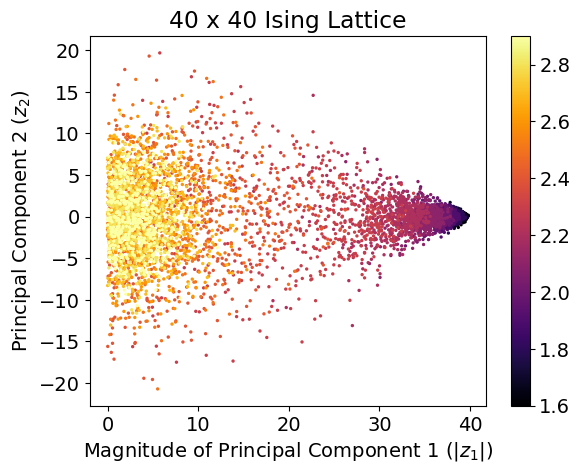

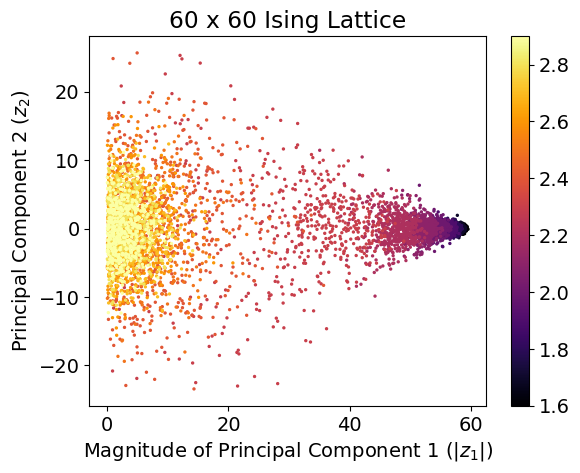

In [13]:
plt.scatter(abs(z1_1), z2_1, c=temps, cmap='inferno', s=2)
plt.xlabel('Magnitude of Principal Component 1 ($|z_1|$)')
plt.ylabel('Principal Component 2 ($z_2$)')
plt.title('20 x 20 Ising Lattice')
plt.colorbar()
plt.show()

plt.scatter(abs(z1_2), z2_2, c=temps, cmap='inferno', s=2)
plt.xlabel('Magnitude of Principal Component 1 ($|z_1|$)')
plt.ylabel('Principal Component 2 ($z_2$)')
plt.title('40 x 40 Ising Lattice')
plt.colorbar()
plt.show()

plt.scatter(abs(z1_3), z2_3, c=temps, cmap='inferno', s=2)
plt.xlabel('Magnitude of Principal Component 1 ($|z_1|$)')
plt.ylabel('Principal Component 2 ($z_2$)')
plt.title('60 x 60 Ising Lattice')
plt.colorbar()
plt.show()

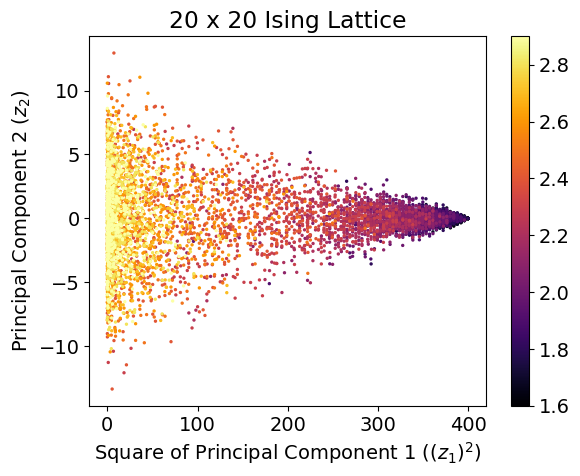

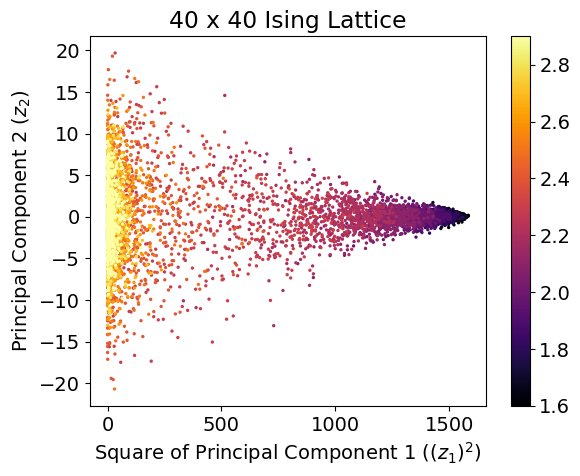

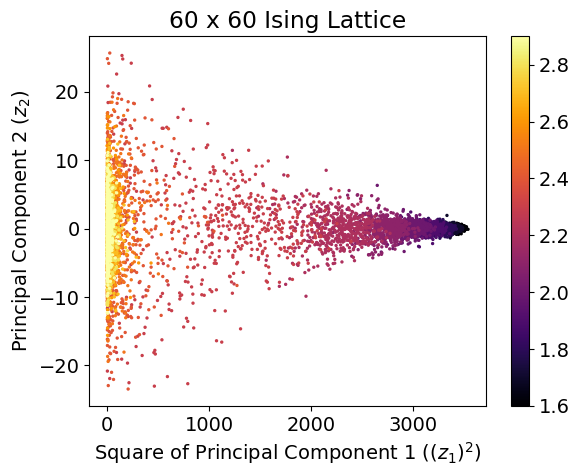

In [14]:
plt.scatter((z1_1)**2, z2_1, c=temps, cmap='inferno', s=2)
plt.xlabel('Square of Principal Component 1 ($(z_1)^2$)')
plt.ylabel('Principal Component 2 ($z_2$)')
plt.title('20 x 20 Ising Lattice')
plt.colorbar()
plt.show()

plt.scatter((z1_2)**2, z2_2, c=temps, cmap='inferno', s=2)
plt.xlabel('Square of Principal Component 1 ($(z_1)^2$)')
plt.ylabel('Principal Component 2 ($z_2$)')
plt.title('40 x 40 Ising Lattice')
plt.colorbar()
plt.show()

plt.scatter((z1_3)**2, z2_3, c=temps, cmap='inferno', s=2)
plt.xlabel('Square of Principal Component 1 ($(z_1)^2$)')
plt.ylabel('Principal Component 2 ($z_2$)')
plt.title('60 x 60 Ising Lattice')
plt.colorbar()
plt.show()

# Performing the Clustering

In [15]:
def k_means_cluster(points, k):
    '''
    Performs the k-means clustering algorithm, adapted for use on Ising model data
    
    PARAMETERS:
     • points: Set of points which are to be divided into clusters
     • k: Number of clusters we want
     
    RETURNS:
     • clusters: An array of the same length as points, detailing which cluster each belongs to
     This can also plot the points, coloured by cluster, and with the mean, for each iteration of the algorithm.

    '''
    
    xmin = np.amin(points[:,0])
    xmax = np.amax(points[:,0])
    
    means = np.zeros((k,2))
    for i in range(k):
        x = np.random.uniform(0,1)*(xmax-xmin) + xmin
        means[i] = np.array([x, 0])

    
    clusters = np.zeros_like(points.T[0])
    # Old array of clusters for each point
    n_clusters = np.zeros_like(points.T[0])
    # New array of clusters for each point, will be compared to above to check for convergence
    
    change = True
    aaa = 0
    while change and aaa < 10:
        for j,p in enumerate(points):
            p_dists = np.zeros(k)
            for pk in range(k):
                p_dists[pk] = np.sqrt(np.sum((p-means[pk])**2))
            n_clusters[j] = np.argmin(p_dists)
        
        for m in range(len(means)):
            means[m] = np.mean(points[n_clusters == m], axis=0)

#         Uncomment the below to see the plots of each iteration of the clustering
#         for z in range(k):
#             plt.scatter(points[n_clusters==z][:,0], points[n_clusters==z][:,1], s=5, color=colors[z], alpha=0.3)
#             plt.scatter(means[z,0], means[z,1], marker='s', s=100, color=mcolors[z], edgecolor='yellow')
#         plt.xlabel('$z_1^2$')
#         plt.ylabel('$z_2$')
#         plt.show()
        
        if all(n_clusters == clusters):
            change = False
        else:
            clusters = n_clusters
        
        aaa += 1            
    return clusters

In [16]:
def crit_temp(points, clusters):
    c0 = points[clusters==0]
    c1 = points[clusters==1]

    if min(c0.T[0]) < 10: # Identifying which cluster is on the left
        z1L = max(c0.T[0])
        z1R = min(c1.T[0])
    else:
        z1L = max(c1.T[0])
        z1R = min(c0.T[0])

    c_temps = []
    for i in range(len(points)):
        if z1L - 5 < points[i,0] < z1R + 5:
            c_temps.append(temps[i])

    t_c = np.mean(c_temps)
    return t_c

In [17]:
points1 = np.array([(z1_1)**2, z2_1]).T
clusters1 = k_means_cluster(points=points1, k=2)

points2 = np.array([(z1_2)**2, z2_2]).T
clusters2 = k_means_cluster(points=points2, k=2)

points3 = np.array([(z1_3)**2, z2_3]).T
clusters3 = k_means_cluster(points=points3, k=2)

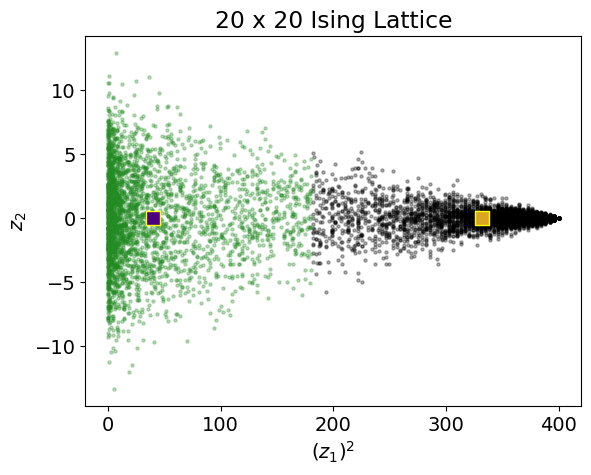

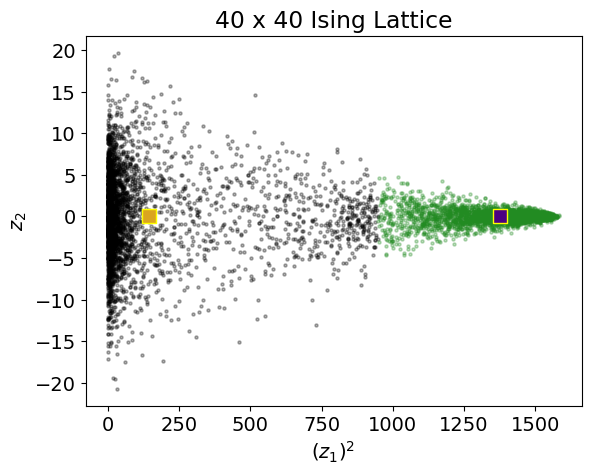

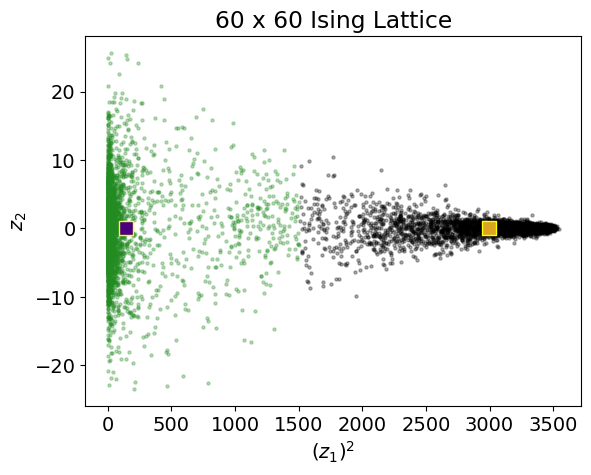

In [18]:
mcolors = ['goldenrod', 'indigo']
colors = ['black', 'forestgreen']

for c in [0,1]:
    mean = np.mean(points1[clusters1==c], axis=0)
    plt.scatter(points1[clusters1==c][:,0], points1[clusters1==c][:,1], s=5, color=colors[c], alpha=0.3)
    plt.scatter(mean[0], mean[1], marker='s', s=100, color=mcolors[c], edgecolor='yellow')
plt.xlabel('$(z_1)^2$')
plt.ylabel('$z_2$')
plt.title('20 x 20 Ising Lattice')
# plt.axvline(190, ls='--', color='purple', label='T = 2.27')
plt.show()

for c in [0,1]:
    mean = np.mean(points2[clusters2==c], axis=0)
    plt.scatter(points2[clusters2==c][:,0], points2[clusters2==c][:,1], s=5, color=colors[c], alpha=0.3)
    plt.scatter(mean[0], mean[1], marker='s', s=100, color=mcolors[c], edgecolor='yellow')
plt.xlabel('$(z_1)^2$')
plt.ylabel('$z_2$')
plt.title('40 x 40 Ising Lattice')
# plt.axvline(710, ls='--', color='purple', label='T = 2.27')
plt.show()

for c in [0,1]:
    mean = np.mean(points3[clusters3==c], axis=0)
    plt.scatter(points3[clusters3==c][:,0], points3[clusters3==c][:,1], s=5, color=colors[c], alpha=0.3)
    plt.scatter(mean[0], mean[1], marker='s', s=100, color=mcolors[c], edgecolor='yellow')
plt.xlabel('$(z_1)^2$')
plt.ylabel('$z_2$')
plt.title('60 x 60 Ising Lattice')
# plt.axvline(1700, ls='--', color='purple', label='T = 2.27')
plt.show()

In [19]:
t_c_1 = crit_temp(points1, clusters1)
t_c_2 = crit_temp(points2, clusters2)
t_c_3 = crit_temp(points3, clusters3)

print('The critical temperature for the 20 x 20 Ising Lattice is', t_c_1)
print('The critical temperature for the 40 x 40 Ising Lattice is', t_c_2)
print('The critical temperature for the 60 x 60 Ising Lattice is', t_c_3)

The critical temperature for the 20 x 20 Ising Lattice is 2.3447761194029857
The critical temperature for the 40 x 40 Ising Lattice is 2.200000000000001
The critical temperature for the 60 x 60 Ising Lattice is 2.3000000000000007
